In [10]:
import pandas as pd

# Try tab-separated
df = pd.read_csv("./data/photos.csv000", sep="\t")
print(df.columns)
print(df.head())



Index(['photo_id', 'photo_url', 'photo_image_url', 'photo_submitted_at',
       'photo_featured', 'photo_width', 'photo_height', 'photo_aspect_ratio',
       'photo_description', 'photographer_username', 'photographer_first_name',
       'photographer_last_name', 'exif_camera_make', 'exif_camera_model',
       'exif_iso', 'exif_aperture_value', 'exif_focal_length',
       'exif_exposure_time', 'photo_location_name', 'photo_location_latitude',
       'photo_location_longitude', 'photo_location_country',
       'photo_location_city', 'stats_views', 'stats_downloads',
       'ai_description', 'ai_primary_landmark_name',
       'ai_primary_landmark_latitude', 'ai_primary_landmark_longitude',
       'ai_primary_landmark_confidence', 'blur_hash'],
      dtype='object')
      photo_id                                photo_url  \
0  oSf8ePoG9NU  https://unsplash.com/photos/oSf8ePoG9NU   
1  DlsOa5moK4w  https://unsplash.com/photos/DlsOa5moK4w   
2  XBGacbT3vXI  https://unsplash.com/photos/XBGac

In [91]:
!pip install selenium

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for selenium from https://files.pythonhosted.org/packages/7e/c0/092fde36918574e144613de73ba43c36ab8d31e7d36bb44c35261909452d/selenium-4.33.0-py3-none-any.whl.metadata
  Obtaining dependency information for urllib3[socks]~=2.4.0 from https://files.pythonhosted.org/packages/6b/11/cc635220681e93a0183390e26485430ca2c7b5f9d33b15c74c2861cb8091/urllib3-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for trio~=0.30.0 from https://files.pythonhosted.org/packages/69/8e/3f6dfda475ecd940e786defe6df6c500734e686c9cd0a0f8ef6821e9b2f2/trio-0.30.0-py3-none-any.whl.metadata
  Obtaining dependency information for trio-websocket~=0.12.2 from https://files.pythonhosted.org/packages/c7/19/eb640a397bba49ba49ef9dbe2e7e5c04202ba045b6ce2ec36e9cadc51e04/trio_websocket-0.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for certifi>=2025.4.26 from https://files.pythonhosted.org/packages/4a/7e/3db2bd1b1f9e95f7cddca6d6e75e2f2bd9f51b1246e546d88add

In [11]:
import pandas as pd

# Try tab-separated
df = pd.read_csv("./data/keywords.csv000", sep="\t")
print(df.columns)
print(df.head())



Index(['photo_id', 'keyword', 'ai_service_1_confidence',
       'ai_service_2_confidence', 'suggested_by_user',
       'user_suggestion_source'],
      dtype='object')
      photo_id     keyword  ai_service_1_confidence  ai_service_2_confidence  \
0  zzwTUqvzIFg    universe                96.990120                      NaN   
1  zzwTUqvzIFg  wallpapers                      NaN                      NaN   
2  zzwTUqvzIFg      nature                99.825333                      NaN   
3  zzwTUqvzIFg   astronomy                96.990120                      NaN   
4  zzwTUqvzIFg   milky way                43.827744                      NaN   

  suggested_by_user user_suggestion_source  
0                 f                    NaN  
1                 t                  admin  
2                 t                  admin  
3                 f                    NaN  
4                 f                    NaN  


In [12]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from collections import defaultdict

# Load data
df_photos = pd.read_csv("./data/photos.csv000",sep="\t")
df_keywords = pd.read_csv("./data/keywords.csv000",sep="\t")

# Build {photo_id: [keywords]} lookup
photo_keywords = defaultdict(list)
for _, row in df_keywords.iterrows():
    if isinstance(row["keyword"], str) and float(row["ai_service_1_confidence"]) >= 0.6:
        photo_keywords[row["photo_id"]].append(row["keyword"])

# Get enriched description
def get_description(row):
    desc = ""
    if pd.notna(row["ai_description"]):
        desc = row["ai_description"]
    elif pd.notna(row["photo_description"]):
        desc = row["photo_description"]
    else:
        desc = f"Photo by {row['photographer_username']}"
    
    keywords = " ".join(photo_keywords.get(row["photo_id"], []))
    if keywords:
        return f"{desc}. Tags: {keywords}"
    return desc

# Init CLIP model
model = SentenceTransformer("clip-ViT-B-32")
os.makedirs("downloaded_images", exist_ok=True)

# Store final data
image_paths = []
image_embeddings = []
text_embeddings = []

# Process top N photos (change to full later)
for _, row in tqdm(df_photos.head(500).iterrows(), total=500):
    try:
        url = row["photo_image_url"]
        description = get_description(row)
        photo_id = row["photo_id"]

        # Download image
        response = requests.get(url, timeout=10)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        # Save locally
        local_path = f"downloaded_images/{photo_id}.jpg"
        img.save(local_path)

        # Embed
        img_emb = model.encode(img, normalize_embeddings=True)
        txt_emb = model.encode(description, normalize_embeddings=True)

        image_paths.append(local_path)
        image_embeddings.append(img_emb)
        text_embeddings.append(txt_emb)

    except Exception as e:
        print(f"Skipping {row['photo_id']}: {e}")

# Save .npy
np.save("image_paths.npy", np.array(image_paths))
np.save("image_embeddings.npy", np.array(image_embeddings))
np.save("text_embeddings.npy", np.array(text_embeddings))

print(f"\nSaved {len(image_paths)} image-text pairs with embeddings.")


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|█████████████████████████████████████████| 500/500 [07:28<00:00,  1.11it/s]


✅ Saved 500 image-text pairs with embeddings.


In [23]:
# search.py
import numpy as np
import faiss

# Load data
image_paths = np.load("image_paths.npy", allow_pickle=True)
image_embeddings = np.load("image_embeddings.npy")

# Normalize for cosine similarity
image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

# Build FAISS index
d = image_embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(image_embeddings)

# Search function
def search_clip(query_vector, top_k=5):
    query_vector = query_vector / np.linalg.norm(query_vector)
    query_vector = np.array([query_vector], dtype="float32")  # cast to float32
    D, I = index.search(query_vector, top_k)
    results = [{"path": image_paths[i], "score": float(D[0][j])} for j, i in enumerate(I[0])]
    return results



In [24]:
# clip_encoder.py
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32")

def embed_text(text):
    return model.encode(text, normalize_embeddings=True)


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [25]:
from sentence_transformers import SentenceTransformer

# Load a paraphrase model
clip_model = SentenceTransformer("clip-ViT-B-32")


In [26]:
from symspellpy import SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("./data/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


def correct_spelling(query):
    # Correct the spelling of the query
    suggestions = sym_spell.lookup_compound(query, max_edit_distance=2)
    return suggestions[0].term if suggestions else query


In [62]:
import spacy

# Load a spaCy model for NER
nlp = spacy.load("en_core_web_sm")

def extract_named_entities(query):
    # Process the query
    doc = nlp(query)
    # Extract entities
    entities = [ent.text for ent in doc.ents]
    return entities

def prioritize_by_entities(query, entities):
    # You can use entities to prioritize the images
    query_expanded = query + " " + " ".join(entities)
    return query_expanded


In [65]:
from PIL import Image
import matplotlib.pyplot as plt

def show_results(results):
    plt.figure(figsize=(15, 3))
    for i, r in enumerate(results):
        try:
            img = Image.open(r['path'])
            print(r['path'])
            plt.subplot(1, len(results), i + 1)
            plt.imshow(img)
            plt.title(f"{r['score']:.2f}")
            plt.axis("off")
        except Exception as e:
            print(f"Could not open image: {r['path']}", e)
    plt.tight_layout()
    plt.show()

# Run it



In [56]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load fine-tuned T5-small model and tokenizer
model_path = "./spellfix_t5_small"  # or wherever your checkpoint is
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

def correct_with_t5(input_text, model, tokenizer, max_len=64):
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=max_len)
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=max_len, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


downloaded_images/EyBKbpPCW7A.jpg
downloaded_images/-87JyMb9ZfU.jpg
downloaded_images/5ErbZB4VY3M.jpg
downloaded_images/kpAXYoXSeuY.jpg
downloaded_images/rRGTgjHQHDQ.jpg


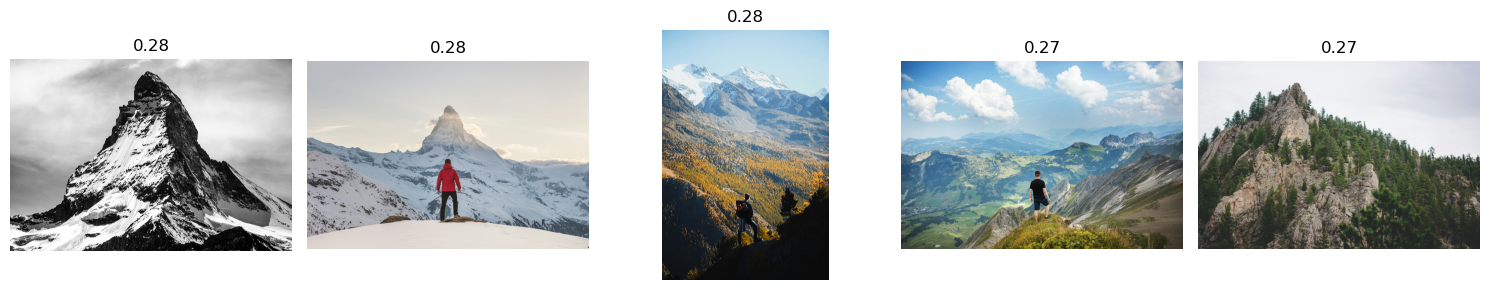

downloaded_images/EyBKbpPCW7A.jpg
downloaded_images/-87JyMb9ZfU.jpg
downloaded_images/5ErbZB4VY3M.jpg
downloaded_images/kpAXYoXSeuY.jpg
downloaded_images/rRGTgjHQHDQ.jpg


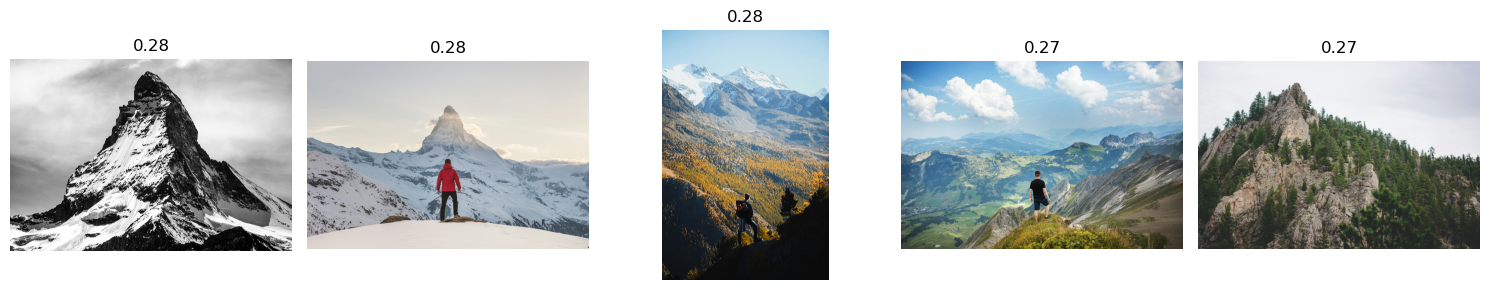

In [66]:
def process_query_clean(query):
    corrected = correct_spelling(query)
    entities = extract_named_entities(corrected)
    prioritized_query = prioritize_by_entities(corrected, entities)

    # Step: Convert prioritized query to CLIP embedding
    variations = [
        prioritized_query,
        f"A picture of {prioritized_query}",
        f"Photograph showing {prioritized_query}",
        f"Scene with {prioritized_query}"
    ]
    vectors = clip_model.encode(variations, normalize_embeddings=True)
    return vectors.mean(axis=0)  # Final vector for search


def process_query_clean_t5(query):
    # Step 1: Spell correct using T5
    corrected = correct_with_t5(query, model, tokenizer)

    # Step 2: Generate query variations (semantic context only)
    variations = [
        corrected,
        f"A picture of {corrected}",
        f"Photograph showing {corrected}",
        f"Scene with {corrected}"
    ]

    vectors = clip_model.encode(variations, normalize_embeddings=True)
    return vectors.mean(axis=0)


# Process the user's query
user_query = "a girl standing in front of a mountain"
query_embedding = process_query_clean(user_query)
query_embedding_t5=process_query_clean_t5(user_query)

# Use this query_embedding in the search system
results = search_clip(query_embedding, top_k=5)
show_results(results)

results = search_clip(query_embedding_t5, top_k=5)
show_results(results)


In [59]:
def process_query(query):
    # Step 1: Spell correct using T5
    corrected_query=correct_spelling(query)
    corrected_pass1 = correct_with_t5(corrected_query, model, tokenizer)
    corrected= correct_with_t5(query, model, tokenizer)
    candidates=[]
    candidates.append(query)
    candidates.append(corrected_query)
    candidates.append(corrected_pass1)
    candidates.append(corrected)
    scores = [(c, score_sentence_with_gpt2(c, gpt2_model, gpt2_tokenizer, device)) for c in candidates]
    sorted_scores = sorted(scores, key=lambda x: x[1])  # Sort by loss

    best_candidate = sorted_scores[0][0]
    print(f"Best correction: {best_candidate}")

    # Step 2: Generate query variations (semantic context only)
    variations = [
        best_candidate,
        f"A picture of {best_candidate}",
        f"Photograph showing {best_candidate}",
        f"Scene with {best_candidate}"
    ]

    vectors = clip_model.encode(variations, normalize_embeddings=True)
    return vectors.mean(axis=0)

a bot sailing ovr the ocen at sunsat
a bot sailing or the open at sunset
a boat sailing or the open at sunset
a bot sailing over the ocean at sunsat
Best correction: a boat sailing or the open at sunset


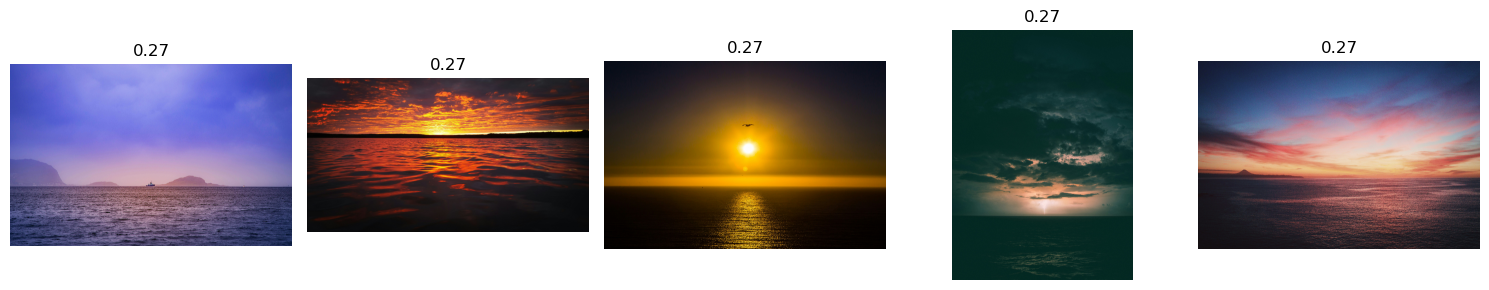

beuatiful sceneri of mountians
beautiful scenery of mountains
beautiful scenery of mountains
beutiful scene of mountainians
Best correction: beautiful scenery of mountains


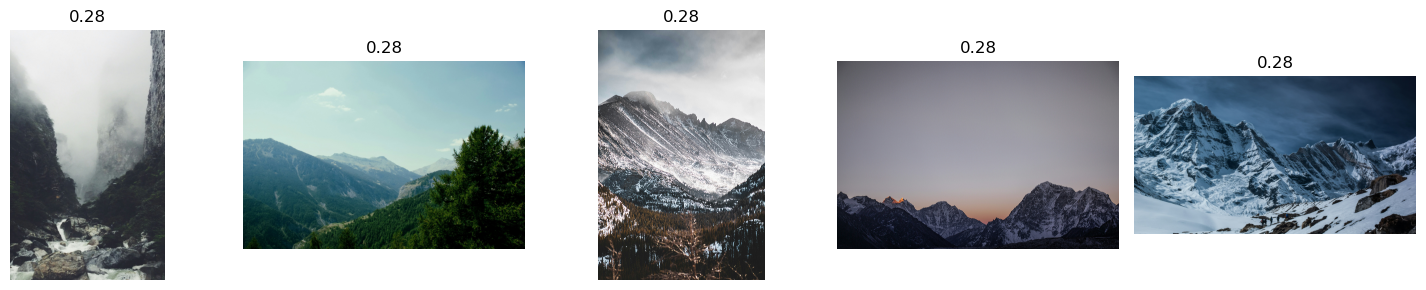

this is a wondeful exmaple of nature
this is a wonderful example of nature
this is a wonderful example of nature
this is a wondeful exmaple of nature
Best correction: this is a wonderful example of nature


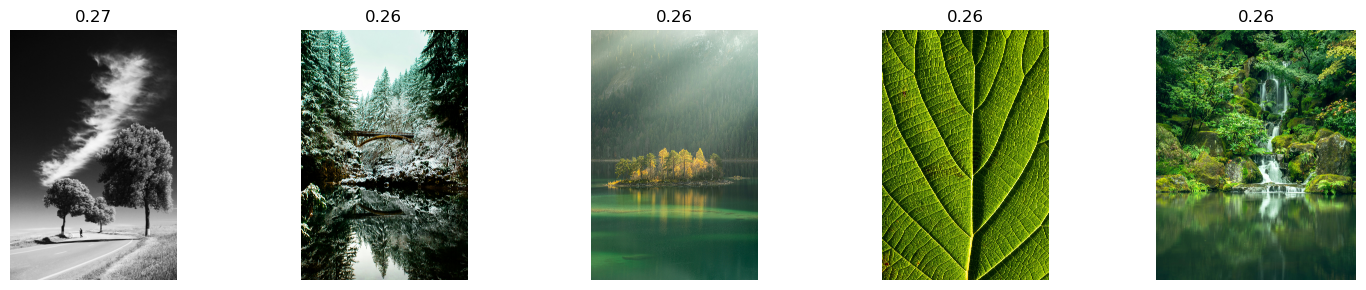

a pictre showing a cta on the roff
a picture showing a cat on the off
a picture showing a cat on the off
a picture showing a car on the road
Best correction: a picture showing a car on the road


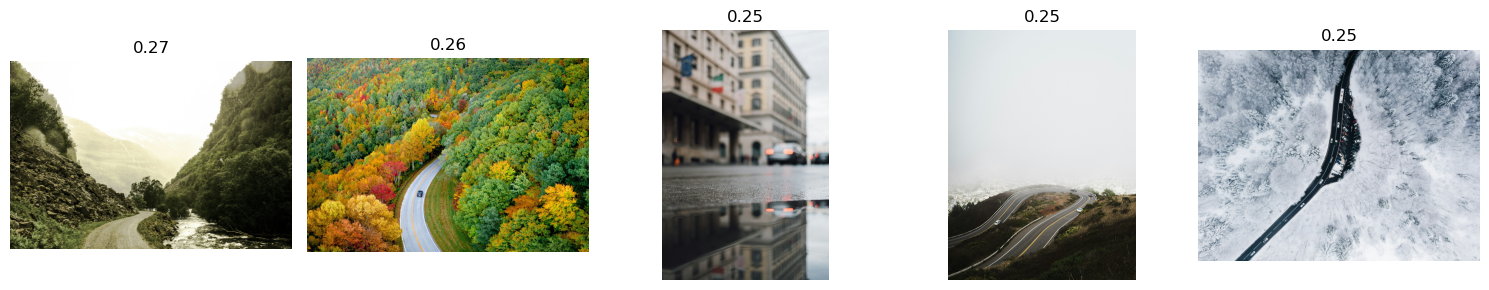

sunrize view at the bech with boat
sunrise view at the beach with boat
sunrise view at the beach with boat
sunrize view at the beach with boat
Best correction: sunrise view at the beach with boat


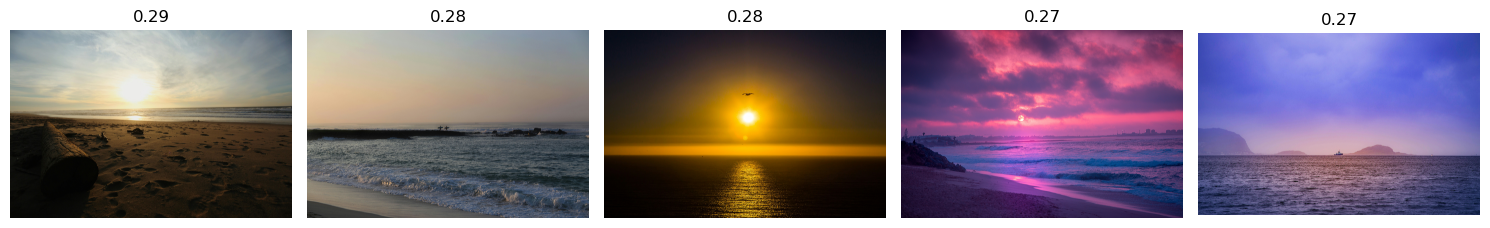

the forst is ful of treas and floers
the first is full of treas and flowers
the first is full of trees and flowers
the forst is filled with trees and flowers
Best correction: the forst is filled with trees and flowers


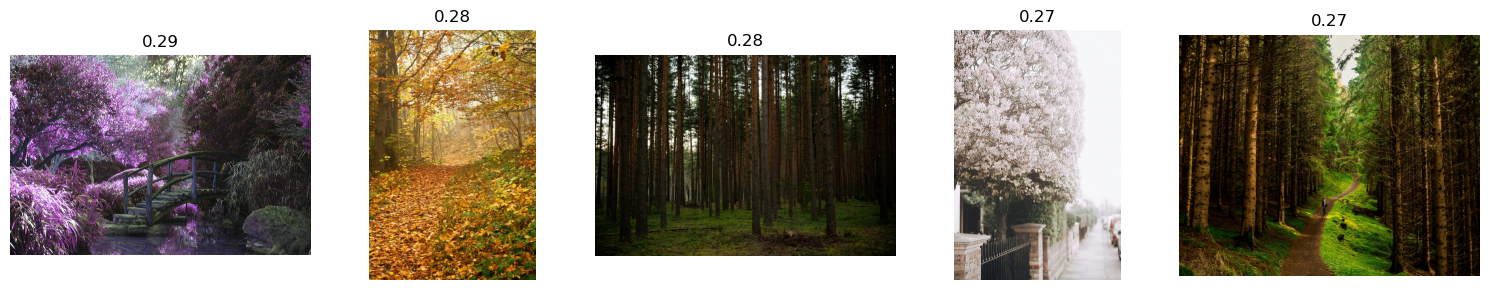

a car parked under teh brdige
a car parked under the bridge
a car parked under the bridge
a car parked under a tree
Best correction: a car parked under a tree


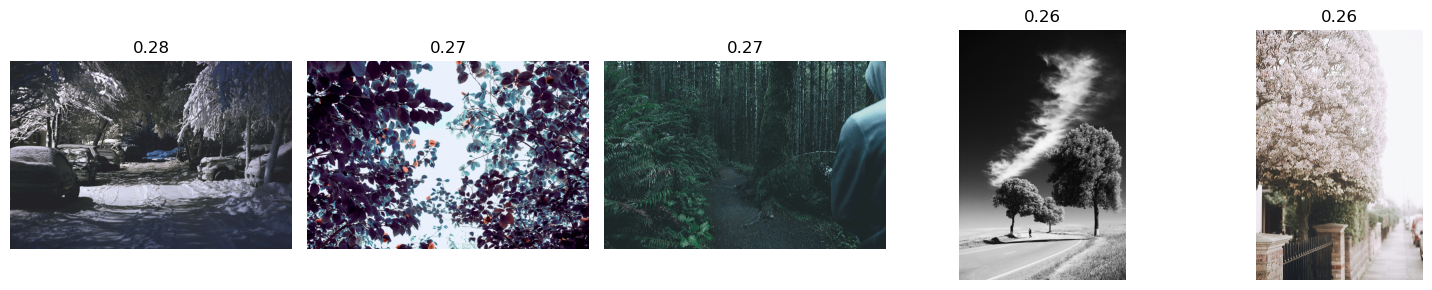

he is sittng on chaor near the oecan
he is sitting on chair near the ocean
he is sitting on chair near the ocean
he is sitting on a boat near the ocean
Best correction: he is sitting on a boat near the ocean


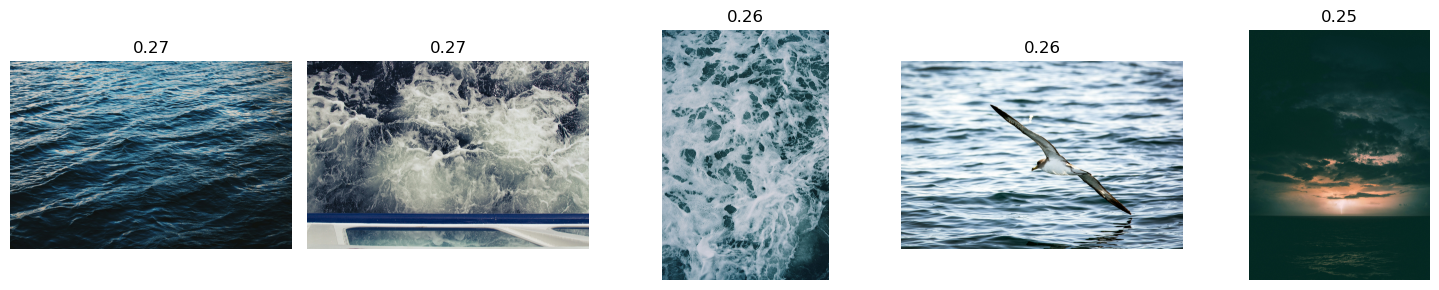

a girl staanding in fron of a mountan
a girl standing in from of a mountain
a girl standing in from a mountain
a girl standing in front of a mountain
Best correction: a girl standing in front of a mountain


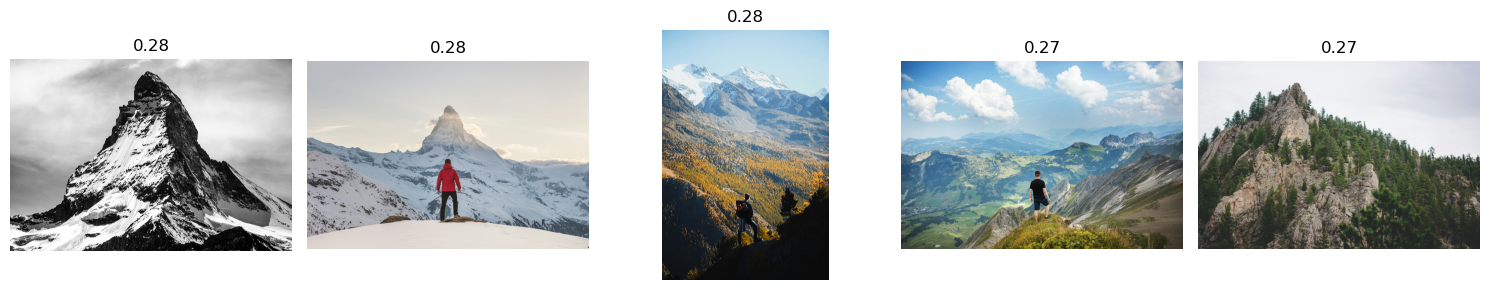

bluu sky aboev the sand dunes
blue sky above the sand dunes
blue sky above the waves
blue sky above the sand dunes
Best correction: blue sky above the sand dunes


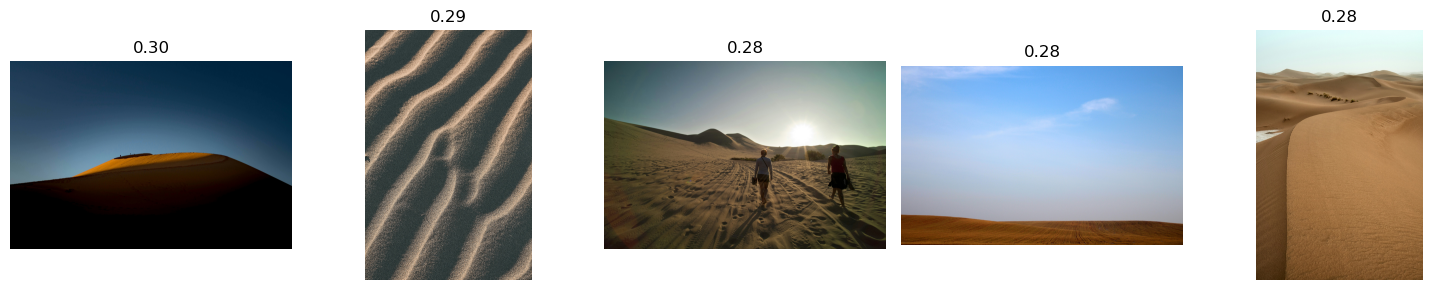

In [60]:
noisy_prompts = [
    "a bot sailing ovr the ocen at sunsat",
    "beuatiful sceneri of mountians",
    "this is a wondeful exmaple of nature",
    "a pictre showing a cta on the roff",
    "sunrize view at the bech with boat",
    "the forst is ful of treas and floers",
    "a car parked under teh brdige",
    "he is sittng on chaor near the oecan",
    "a girl staanding in fron of a mountan",
    "bluu sky aboev the sand dunes"
]
for user_query in noisy_prompts:
    print(user_query)
    query_embedding = process_query(user_query)

    
    results = search_clip(query_embedding, top_k=5)
    show_results(results)
    

In [45]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [46]:
def score_sentence_with_gpt2(sentence, model, tokenizer, device="cpu"):
    inputs = tokenizer.encode(sentence, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(inputs, labels=inputs)
    loss = outputs.loss.item()
    return loss


In [100]:
import asyncio
from playwright.async_api import async_playwright
import pandas as pd

async def collect_captions(page, site, query, scrolls):
    urls = {
        "unsplash": f"https://unsplash.com/s/photos/{query}",
        "pexels": f"https://www.pexels.com/search/{query}/",
        "pinterest": f"https://www.pinterest.com/search/pins/?q={query}"
    }
    await page.goto(urls[site])
    await page.wait_for_timeout(3000)

    captions = set()
    for _ in range(scrolls):
        await page.mouse.wheel(0, 8000)
        await page.wait_for_timeout(2000)

        if site == "unsplash":
            elements = await page.query_selector_all("figure img[alt]")
        elif site == "pexels":
            elements = await page.query_selector_all("article img[alt]")
        elif site == "pinterest":
            elements = await page.query_selector_all("div[data-test-id='pin'] img[alt]")

        for el in elements:
            alt = await el.get_attribute("alt")
            if alt:
                captions.add(alt.strip())

    return list(captions)

async def scrape_sites(topics, scrolls=6):
    data = []
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        for topic in topics:
            for site in ["unsplash", "pexels", "pinterest"]:
                print(f"Scraping {site} for topic: {topic}")
                try:
                    caps = await collect_captions(page, site, topic, scrolls)
                    for caption in caps:
                        data.append({"caption": caption, "topic": topic, "source": site})
                except Exception as e:
                    print(f"Error scraping {site}: {e}")
        await browser.close()
    return data

# Run this inside Jupyter
topics = [
    "beach", "mountains", "city", "people", "sky", "food", "dogs", "cars", "architecture",
    "night", "festival", "rain", "flowers", "market", "fashion", "train", "countryside", 
    "desert", "birds", "lakes", "bridges", "boats", "sports", "sunrise", "snow"
]
scrolls = 25
data = await scrape_sites(topics, scrolls)
df = pd.DataFrame(data)
df.to_csv("image_captions_scraped.csv", index=False)
print(f"Saved {len(df)} captions to image_captions_scraped.csv")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Scraping unsplash for topic: beach
Scraping pexels for topic: beach
Scraping pinterest for topic: beach
Scraping unsplash for topic: mountains
Scraping pexels for topic: mountains
Scraping pinterest for topic: mountains
Scraping unsplash for topic: city
Scraping pexels for topic: city
Scraping pinterest for topic: city
Scraping unsplash for topic: people
Scraping pexels for topic: people
Scraping pinterest for topic: people
Scraping unsplash for topic: sky
Scraping pexels for topic: sky
Scraping pinterest for topic: sky
Scraping unsplash for topic: food
Scraping pexels for topic: food
Scraping pinterest for topic: food
Scraping unsplash for topic: dogs
Scraping pexels for topic: dogs
Scraping pinterest for topic: dogs
Scraping unsplash for topic: cars
Scraping pexels for topic: cars
Scraping pinterest for topic: cars
Scraping unsplash for topic: architecture
Scraping pexels for topic: architecture
Scraping pinterest for topic: architecture
Scraping unsplash for topic: night
Scraping pe

In [101]:
import random
import pandas as pd

def inject_noise(text, prob=0.2):
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < prob:
            op = random.choice(['swap', 'drop', 'replace'])
            if op == 'swap' and i < len(chars)-1:
                chars[i], chars[i+1] = chars[i+1], chars[i]
            elif op == 'drop':
                chars[i] = ''
            elif op == 'replace':
                chars[i] = random.choice('abcdefghijklmnopqrstuvwxyz')
    return ''.join(chars)

df = pd.read_csv("image_captions_scraped.csv")
df = df[df['caption'].apply(lambda x: isinstance(x, str) and len(x.split()) > 3)]
df = df.drop_duplicates(subset="caption")

df["noisy"] = df["caption"].apply(lambda x: inject_noise(x.lower()))
df = df[["noisy", "caption"]]
df.columns = ["input_text", "target_text"]

df.to_csv("bert_spellfix_data.csv", index=False)
print(f"Prepared {len(df)} noisy-clean pairs")


Prepared 7740 noisy-clean pairs


In [102]:
df.head()

input_text  \
0                g too gaddafg rulis's ofnoe   
1                  go toavye wravy's profile   
2                gto tderek thomso'ns rpofie   
3  a red chairjishtng on top of a andy becwh   
4           go o camille mwnoaflet' psrofile   

                                   target_text  
0                Go to Gaddafi Rusli's profile  
1                  Go to Davey Gravy's profile  
2                Go to Derek Thomson's profile  
3  a red chair sitting on top of a sandy beach  
4            Go to Camille Minouflet's profile

In [1]:

# 2. Imports
import pandas as pd
import torch
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# 3. Load your data
df = pd.read_csv("bert_spellfix_data.csv")  # assuming this file has input_text and target_text
df = df[['input_text', 'target_text']].dropna()

# 4. Tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

# 5. Tokenize + prepare data
def tokenize_data(examples):
    inputs = tokenizer(examples['input_text'], padding="max_length", truncation=True, max_length=64)
    targets = tokenizer(examples['target_text'], padding="max_length", truncation=True, max_length=64)

    input_ids = torch.tensor(inputs["input_ids"])
    labels = torch.tensor(targets["input_ids"])

    # Replace padding token labels with -100 so they're ignored in loss
    labels[labels == tokenizer.pad_token_id] = -100
    return {"input_ids": input_ids, "attention_mask": torch.tensor(inputs["attention_mask"]), "labels": labels}

class SpellFixDataset(Dataset):
    def __init__(self, df):
        self.samples = [tokenize_data(row) for _, row in df.iterrows()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

train_df, val_df = train_test_split(df, test_size=0.1)
train_dataset = SpellFixDataset(train_df)
val_dataset = SpellFixDataset(val_df)

# 6. Define trainer
training_args = TrainingArguments(
    output_dir="./spellfix_model",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    do_eval=True,
    eval_strategy="steps",  # Changed from evaluation_strategy
    eval_steps=500
)


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # we're doing sequence-to-sequence style, not MLM
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# 7. Train the model
trainer.train()

# 8. Save the model
trainer.save_model("./spellfix_model")
tokenizer.save_pretrained("./spellfix_model")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/var/folders/fh/wl7qvgcs2vg_xvwzgbw0jf7h0000gn/T/ipykernel_61950/3174491345.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/d

/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


('./spellfix_model/tokenizer_config.json',
 './spellfix_model/special_tokens_map.json',
 './spellfix_model/vocab.txt',
 './spellfix_model/added_tokens.json')

In [2]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

model_path = "./spellfix_model"  # or your actual path if saved elsewhere

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
model.eval()


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [5]:
def correct_with_masking(text, top_k=1):
    tokens = tokenizer.tokenize(text)
    corrected_tokens = tokens.copy()

    for i, token in enumerate(tokens):
        # Skip special tokens
        if token in tokenizer.all_special_tokens:
            continue

        # Create input with masked token
        masked_tokens = tokens.copy()
        masked_tokens[i] = tokenizer.mask_token
        masked_text = tokenizer.convert_tokens_to_string(masked_tokens)
        inputs = tokenizer(masked_text, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, i]
            predicted_ids = logits.topk(top_k).indices

        predicted_token = tokenizer.decode(predicted_ids[0])
        # Replace only if prediction is different and alphabetic
        if predicted_token.isalpha() and predicted_token != token:
            corrected_tokens[i] = predicted_token

    return tokenizer.convert_tokens_to_string(corrected_tokens)



In [6]:
test_inputs = [
    "g too gaddafg rulis's ofnoe",
    "gto tderek thomso'ns rpofie",
    "a red chairjishtng on top of a andy becwh",
    "go o camille mwnoaflet' psrofile",
    "beuaty of natrue in moutains",
    "a boat on wtaer at sunet"
]

for noisy in test_inputs:
    fixed = correct_with_masking(noisy)
    print(f"Original: {noisy}\nCorrected: {fixed}\n")


Original: g too gaddafg rulis's ofnoe
Corrected: g g too gafg ru ru ' s s ofe

Original: gto tderek thomso'ns rpofie
Corrected: gt gt td tdk thom thom ' ns ns rfie

Original: a red chairjishtng on top of a andy becwh
Corrected: a a red chairshtng on on top of a andy bewh

Original: go o camille mwnoaflet' psrofile
Corrected: go go o camille mwaflet ' ps psfile

Original: beuaty of natrue in moutains
Corrected: be bety of of nate in in moins

Original: a boat on wtaer at sunet
Corrected: a a boat on wta at at sun



In [16]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import T5Tokenizer

class T5SpellFixDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=64):
        self.tokenizer = tokenizer
        self.input_texts = dataframe["input_text"].tolist()
        self.target_texts = dataframe["target_text"].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(self.input_texts[idx], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        target_enc = self.tokenizer(self.target_texts[idx], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt")
        
        return {
            "input_ids": input_enc.input_ids.squeeze(),
            "attention_mask": input_enc.attention_mask.squeeze(),
            "labels": target_enc.input_ids.squeeze()
        }


In [17]:
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer

df = pd.read_csv("bert_spellfix_data.csv")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

tokenizer = T5Tokenizer.from_pretrained("t5-small")

train_dataset = T5SpellFixDataset(train_df, tokenizer)
val_dataset = T5SpellFixDataset(val_df, tokenizer)


In [18]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

model = T5ForConditionalGeneration.from_pretrained("t5-small")

training_args = TrainingArguments(
    output_dir="./t5_spellfix",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    logging_dir="./logs",
    save_steps=500,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


/var/folders/fh/wl7qvgcs2vg_xvwzgbw0jf7h0000gn/T/ipykernel_62201/367480042.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()


/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1744, training_loss=0.7789403178276272, metrics={'train_runtime': 315.3386, 'train_samples_per_second': 88.362, 'train_steps_per_second': 5.531, 'total_flos': 471395494526976.0, 'train_loss': 0.7789403178276272, 'epoch': 4.0})

In [20]:
trainer.save_model("./spellfix_t5_small")
tokenizer.save_pretrained("./spellfix_t5_small")


('./spellfix_t5_small/tokenizer_config.json',
 './spellfix_t5_small/special_tokens_map.json',
 './spellfix_t5_small/spiece.model',
 './spellfix_t5_small/added_tokens.json')

In [12]:
def correct_with_t5(input_text, model, tokenizer, max_len=64):
    model.eval()
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=max_len, truncation=True)
    with torch.no_grad():
        outputs = model.generate(inputs, max_length=max_len, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [15]:
noisy_sentences = [
    "g too gaddafg rulis's ofnoe",
    "gto tderek thomso'ns rpofie",
    "a red chairjishtng on top of a andy becwh",
    "go o camille mwnoaflet' psrofile",
    "beuaty of natrue in moutains",
    "a boat on wtaer at sunet"
]

for sentence in noisy_sentences:
    corrected = correct_with_t5(sentence, model, tokenizer)
    print(f"Original: {sentence}")
    print(f"Corrected: {corrected}\n")


Original: g too gaddafg rulis's ofnoe
Corrected: g too gaddafgrulis's name

Original: gto tderek thomso'ns rpofie
Corrected: Go to Tinderek's profile

Original: a red chairjishtng on top of a andy becwh
Corrected: a red chair sitting on top of a hill

Original: go o camille mwnoaflet' psrofile
Corrected: Go to Camille Mwnoaflet's profile

Original: beuaty of natrue in moutains
Corrected: a picture of a woman in a forest

Original: a boat on wtaer at sunet
Corrected: a boat on a boat at sunset



In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-large")
model = T5ForConditionalGeneration.from_pretrained("t5-large")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [2]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("bert_spellfix_data.csv")  # adjust filename if needed
df = df[["input_text", "target_text"]].dropna()
dataset = Dataset.from_pandas(df)


In [3]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-large")

def preprocess_function(example):
    input_text = "fix: " + example["input_text"]
    target_text = example["target_text"]

    model_inputs = tokenizer(
        input_text, max_length=128, padding="max_length", truncation=True
    )

    labels = tokenizer(
        target_text, max_length=128, padding="max_length", truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

tokenized_dataset = dataset.map(preprocess_function)


Map:   0%|          | 0/7740 [00:00<?, ? examples/s]

In [11]:
from torch.utils.data import Dataset

class SpellFixDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = df["input_text"]
        self.targets = df["target_text"]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        model_inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        model_inputs["labels"] = labels["input_ids"]
        return {k: v.squeeze(0) for k, v in model_inputs.items()}


In [4]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = tokenized_dataset["train"]
val_dataset = tokenized_dataset["test"]


In [12]:
train_dataset = SpellFixDataset(train_dataset, tokenizer)
val_dataset = SpellFixDataset(val_dataset, tokenizer)


In [13]:
from transformers import DataCollatorForSeq2Seq, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./spellfix_t5_large",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    do_eval=True,
    eval_strategy="steps",
    eval_steps=500,
    fp16=False  # Disable mixed precision for MPS
)


data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


/var/folders/fh/wl7qvgcs2vg_xvwzgbw0jf7h0000gn/T/ipykernel_62201/1441599546.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

/Users/naveensasikumar/anaconda3/lib/python3.11/site-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


KeyboardInterrupt: 

In [ ]:
trainer.save_model("./spellfix_t5_large")
tokenizer.save_pretrained("./spellfix_t5_large")
